- Comp47350 - Data Analytics
- 
- Homework2
- 
- This Report focuses on training and evaluating prediction models for a particular problem and dataset. In this analysis, we focus on using data collected by CDC to build a data analytics solution for death risk prediction.
- The goal of this report is to work with CDC data to build and evaluate prediction models that capture the relationship between the Independent Variables and the target feature **death_yn**.

- The Covid-19 pandemic caused widespread health and economic issues, primarily from 2020 until 2022. The Centre for Disease Control (CDC) in the USA has made public their Covid-19 data. The CDC database contains 105 million entries. From this, 50,000 datapoints were randomly selected for data analysis, with 19 features describing the data. The outcome for the target feature “death_yn” is known (i.e., either “yes” or “no”). The CDC dataset was in CSV format, and was parsed with Python 3.11.7 code. 
- 
- Each entry represents a different person, including information such as state and county of residence, age group, sex, race and whether the patient died as a result of illness, among others.
- 
- The dataset has been cleaned prior. Of the original 19 features, 8 remain: case_month, res_state, age_group, sex, race, ethnicity, hosp_yn, and the target feature death_yn. Feature county_fips_code was transformed into county_frequency_size, and 3 additional features were created for the dataset: party, Profile, and seasons. The dataset, "new_features_df1.csv" contains 11 independent variables and the dependent variable, death_yn.

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score, KFold, train_test_split, cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from pdpbox import pdp
import shap


- Information from "Profile" is contained in other features. It was created for the previous assignment to find key demographs, but will interfere with accurate modelling in this assignment (potential multicolinnearity)
- The same is true for "season" and case_month, and case_month will be dropped

In [70]:
df = pd.read_csv(r"C:\Users\35385\Desktop\CS_Spring2024\DataAnal\Homework2\new_features_df1.csv", keep_default_na=True, delimiter=",", skipinitialspace=True, encoding="Windows-1252")
df.drop(columns=["Profile", "case_month"], inplace=True)

In [71]:
# Convert all object-type columns to categorical type
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39947 entries, 0 to 39946
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   res_state              39947 non-null  category
 1   age_group              39947 non-null  category
 2   sex                    39947 non-null  category
 3   race                   39947 non-null  category
 4   ethnicity              39947 non-null  category
 5   hosp_yn                39947 non-null  category
 6   death_yn               39947 non-null  category
 7   county_frequency_size  39947 non-null  category
 8   party                  39947 non-null  category
 9   seasons                39947 non-null  category
dtypes: category(10)
memory usage: 393.1 KB


In [72]:
df.head(10)

,res_state,age_group,sex,race,ethnicity,hosp_yn,death_yn,county_frequency_size,party,seasons
0,CA,65+ years,_M,White,Non_H/L,Yes,Yes,Medium,DEMOCRAT,Spring
1,NY,65+ years,_F,White,Non_H/L,Yes,Yes,Medium,DEMOCRAT,Spring
2,FL,65+ years,_F,White,Non_H/L,No,Yes,Medium,DEMOCRAT,Fall
3,TX,50 to 64 years,_M,White,H/L,Yes,Yes,Very_Large,DEMOCRAT,Summer
4,AZ,65+ years,_M,White,H/L,Yes,Yes,Small,DEMOCRAT,Winter
5,WI,65+ years,_F,White,Non_H/L,Yes,Yes,Medium,REPUBLICAN,Fall
6,MD,65+ years,_F,White,Non_H/L,No,Yes,Small,DEMOCRAT,Spring
7,MN,65+ years,_M,White,Non_H/L,No,Yes,Small,DEMOCRAT,Fall
8,NY,65+ years,_M,White,Non_H/L,No,Yes,Huge,DEMOCRAT,Winter
9,NY,65+ years,_F,White,Non_H/L,No,Yes,Huge,DEMOCRAT,Spring


Frequency Table printed to better understand the dataset.

In [73]:
for column in df.columns:
    print(f"Frequency table for column '{column}':")
    print(df[column].value_counts())
    print("\n")

Frequency table for column 'res_state':
res_state
NY    5301
NC    3759
NJ    3627
FL    3503
OH    2156
TX    2063
IN    2038
MN    2031
CA    1457
MD    1404
AZ    1113
MI    1109
KY     823
PA     785
KS     777
WI     650
VA     647
NV     618
OR     607
SC     599
UT     547
MA     538
IL     437
TN     394
OK     388
ID     301
CO     282
ME     280
DC     274
AL     206
AR     195
RI     161
MT     119
CT     115
WA     114
NH     109
MO      98
NM      76
VT      68
IA      65
LA      50
WY      23
GA      14
MS      13
ND       8
NE       3
AK       2
Name: count, dtype: int64


Frequency table for column 'age_group':
age_group
18 to 49 years    16343
65+ years         11647
50 to 64 years     6657
0 - 17 years       5300
Name: count, dtype: int64


Frequency table for column 'sex':
sex
_F    21144
_M    18803
Name: count, dtype: int64


Frequency table for column 'race':
race
White                                     34049
Black                                      4536
Asian

- **Data Understanding and Preparation:**
- 
- The following section explores the relationships between feature pairs, followed by selecting/transforming promising features based on a given training set.
- 
- The dataframe is divided in two: a 70% training set and 30% test set. The test set will be used later for analysis,
- 
- The features in the training set are then plotted for their pairwise interactions with the target feature. Only values with a count of greater than 200 for a given feature are plotted, for ease of legibility in the graphs, especially for res_state and Profile features

- A subset of categorical features which look promising will be chosen for in-depth discussion and analysis. These will be features where it appears that there is a significant variance across the feature for predicting the target outcome, features for which there appears to be a trend for predicting death_yn etc.

- (1.1) Split the dataset into two datasets: 70% training and 30% test

In [74]:
X = df.drop(columns=['death_yn'])
y = df['death_yn']
y = y.replace({'No': 0, 'Yes': 1})
# Split dataset into training and test sets; random_state ensuring the same test/ training datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print("Training data:\n", pd.concat([X_train, y_train], axis=1))
print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

Training data:
       res_state       age_group sex   race ethnicity hosp_yn  \
36228        IN  50 to 64 years  _M  White   Non_H/L      No   
11671        OR  50 to 64 years  _M  White   Non_H/L      No   
12993        KY       65+ years  _M  White   Non_H/L      No   
17552        MI  50 to 64 years  _M  White   Non_H/L      No   
4017         WA       65+ years  _F  White   Non_H/L      No   
...         ...             ...  ..    ...       ...     ...   
7813         MN       65+ years  _F  White   Non_H/L     Yes   
32511        UT  18 to 49 years  _F  White   Non_H/L      No   
5192         AZ       65+ years  _F  White   Non_H/L     Yes   
12172        NC  18 to 49 years  _M  White   Non_H/L      No   
33003        NY  18 to 49 years  _F  White   Non_H/L      No   

      county_frequency_size       party seasons death_yn  
36228            Very_Small  REPUBLICAN  Winter        0  
11671                 Small    DEMOCRAT  Winter        0  
12993                Medium  REPUBLICA

- (1.2) On the training set, for each categorical feature, plot its pairwise interaction with the target feature.

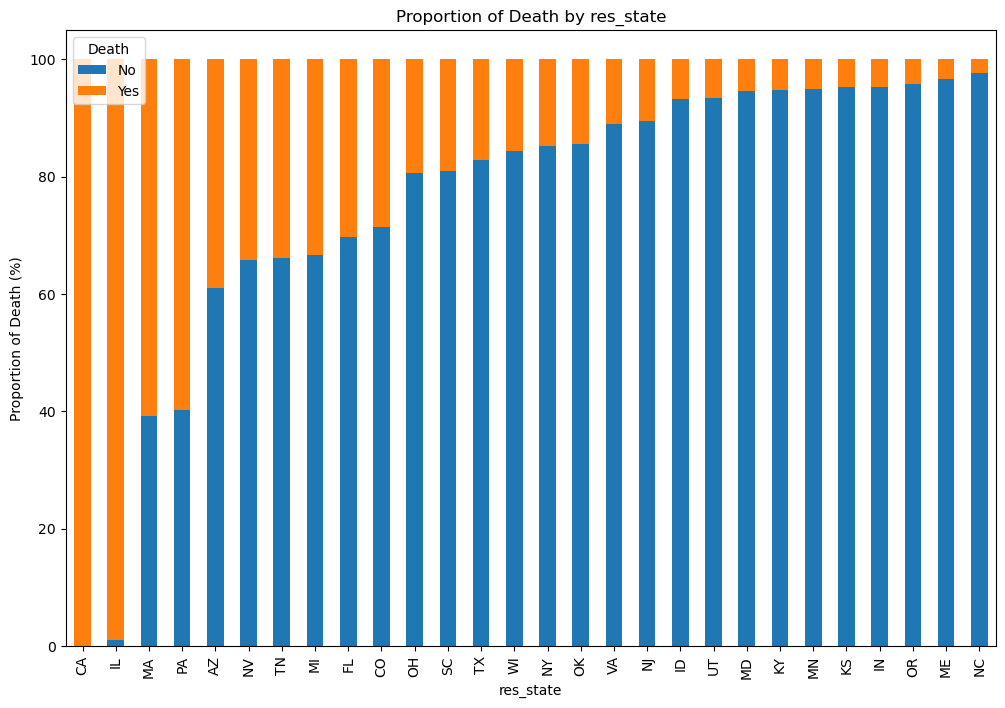

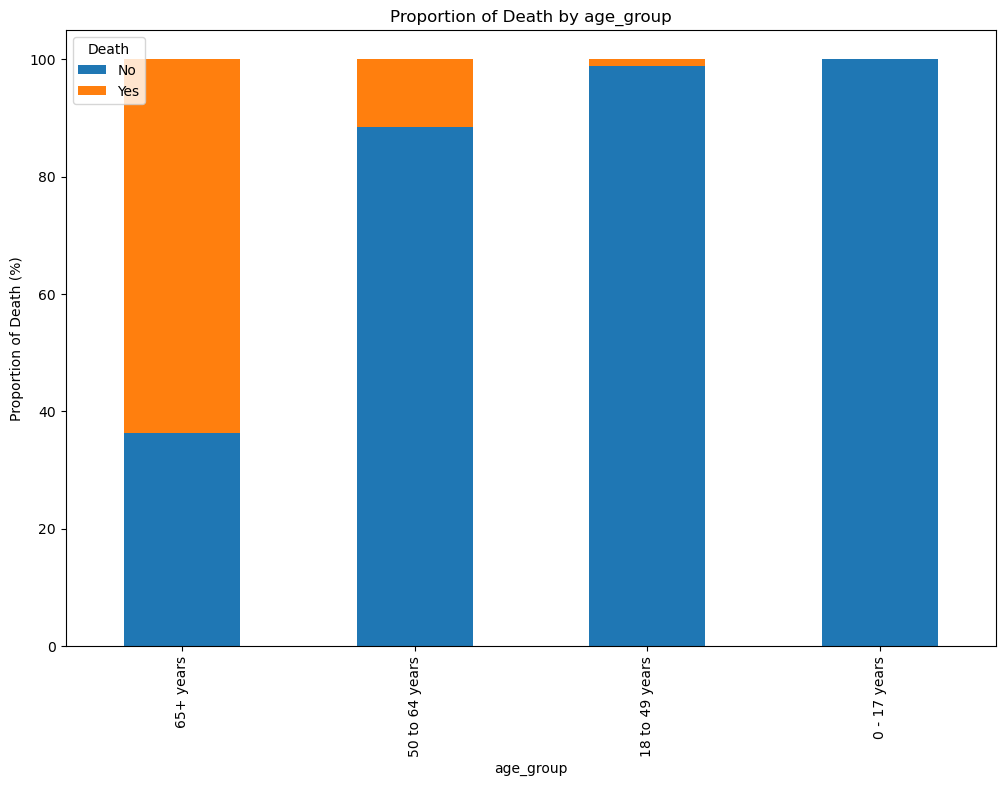

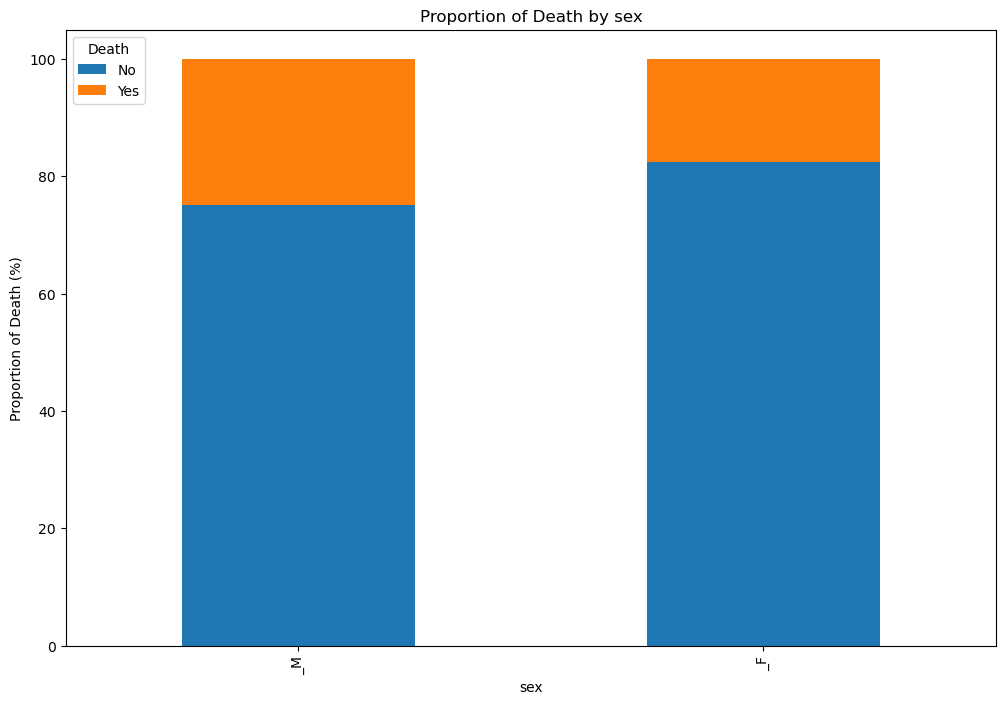

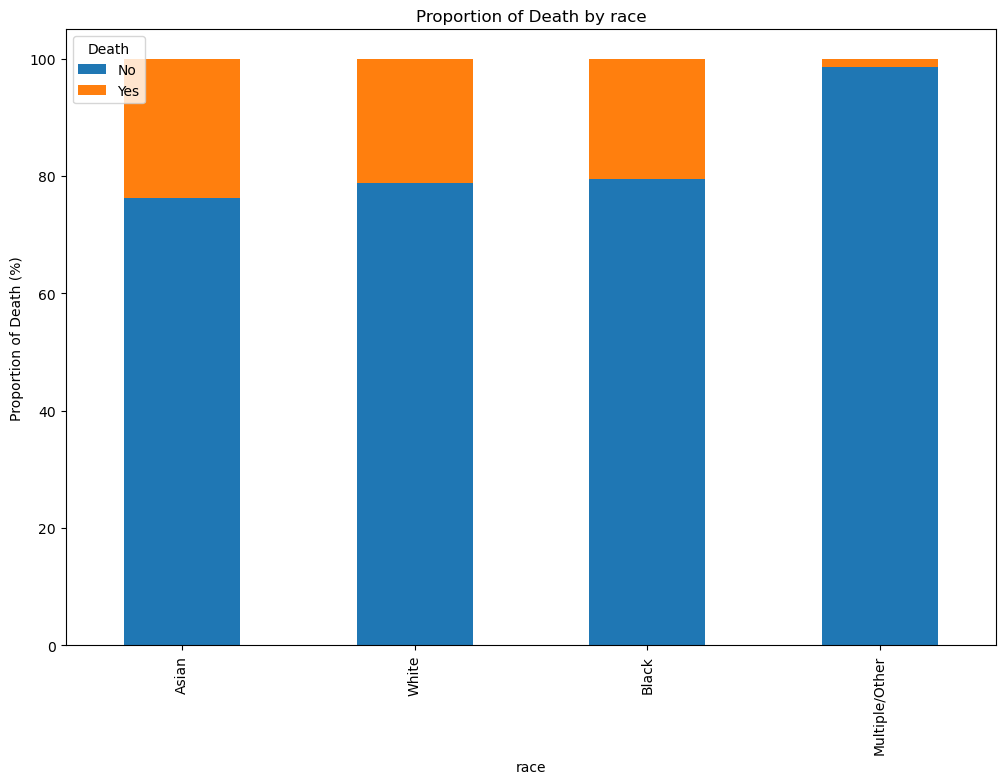

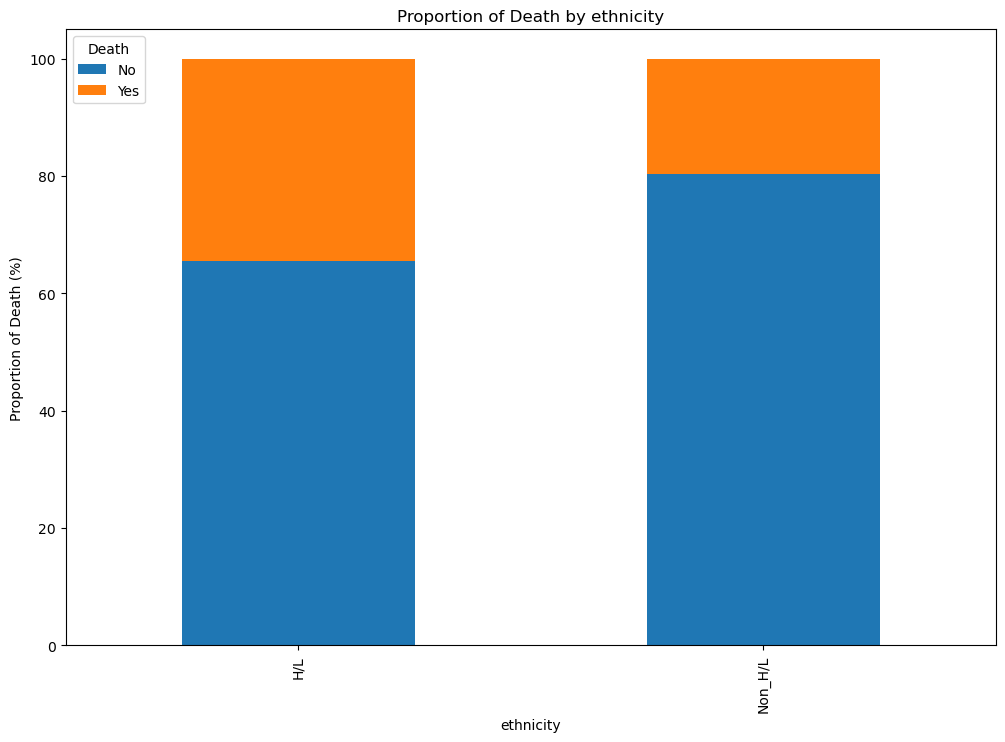

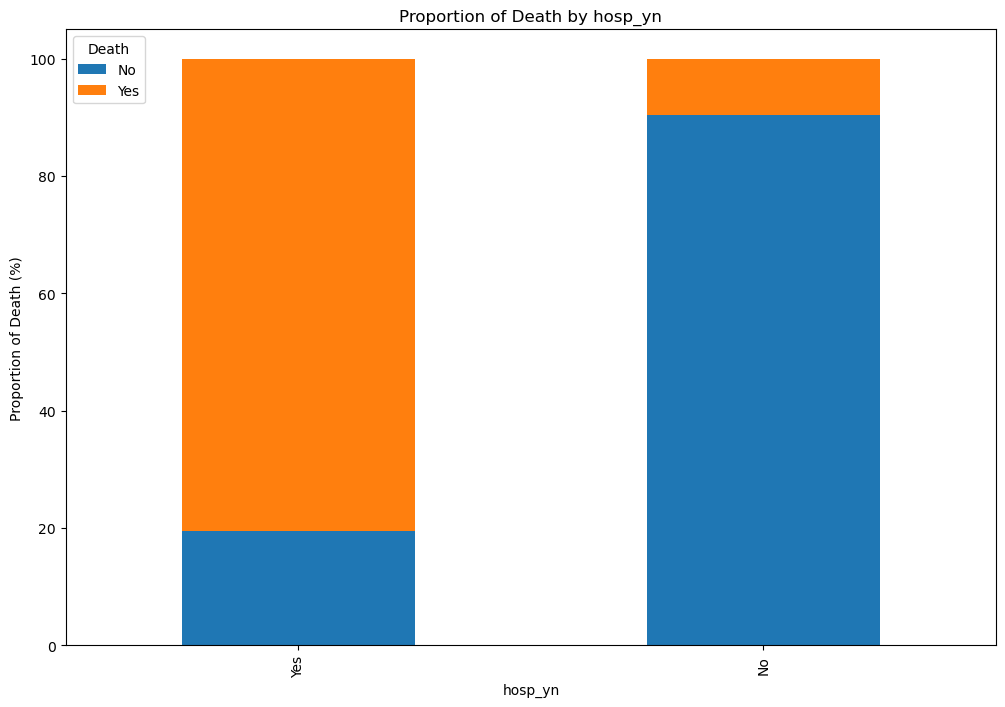

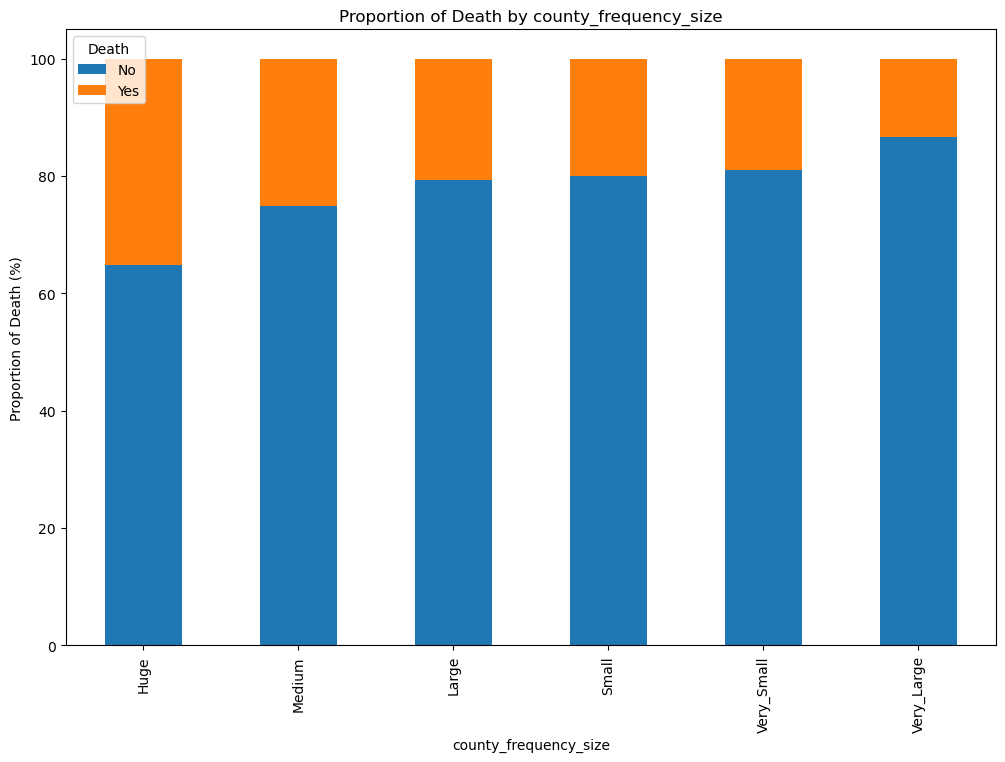

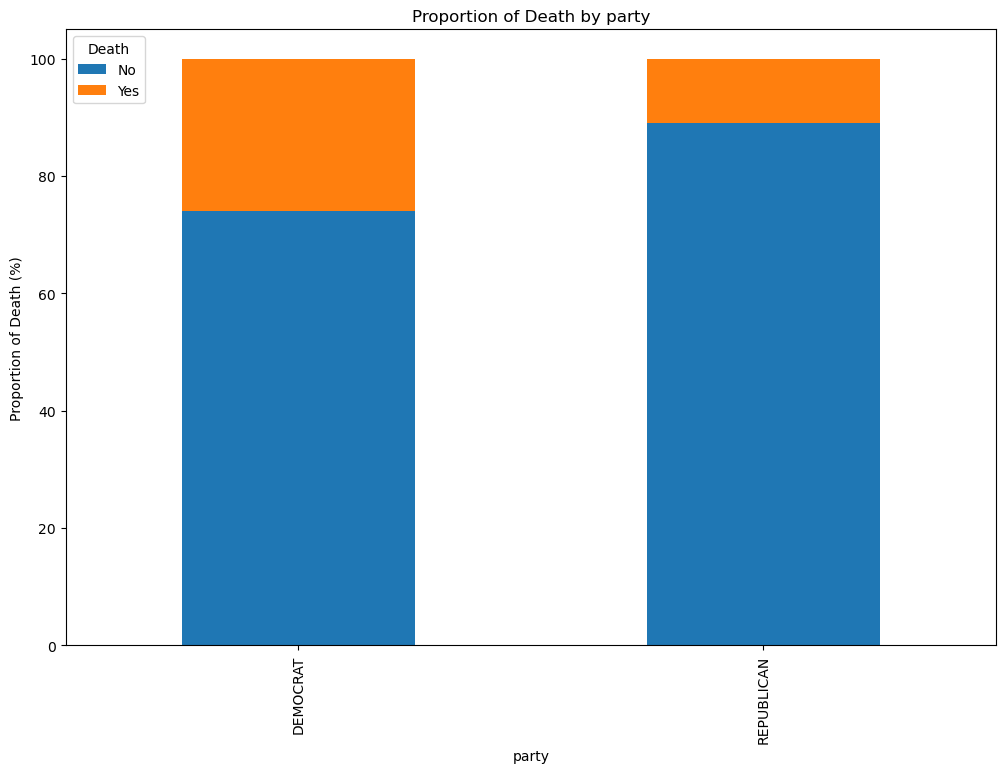

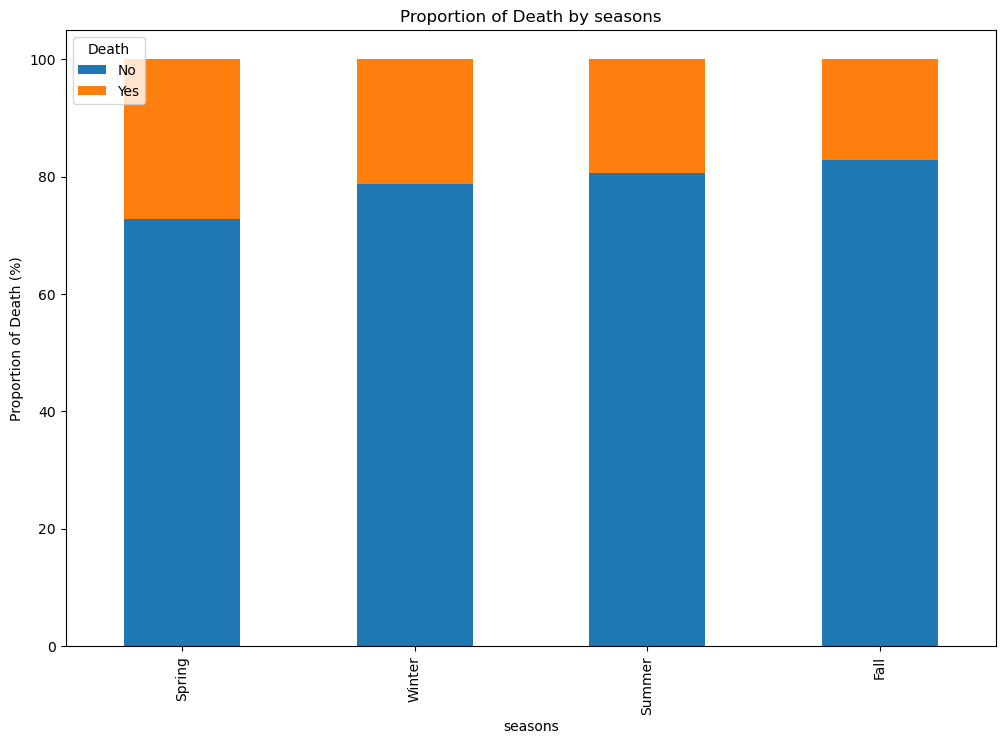

In [75]:
train_data = pd.concat([X_train, y_train], axis=1)

def plot_proportion_of_death(input, feature):
    # Calculate overall counts for each value in the feature
    overall_counts = input[feature].value_counts()

    # Filter features where overall count for any value is greater than 200: allows for better graphing
    valid_features = overall_counts[overall_counts > 200].index.tolist()

    # Calculate counts of 0 and 1 for each feature
    death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)

    # Filter out only the valid values in the feature
    death_counts = death_counts.loc[valid_features]

    #proportion of death per feature category
    proportion_death_feature = death_counts.div(death_counts.sum(axis=1), axis=0) * 100

    # Sort based on highest death "Yes" proportion
    sorted_feature = proportion_death_feature.sort_values(by=1, ascending=False)

    sorted_feature.plot(kind="bar", stacked=True, figsize=(12, 8))
    plt.title(f"Proportion of Death by {feature}")
    plt.ylabel("Proportion of Death (%)")
    plt.xlabel(feature)
    plt.legend(title="Death", labels=["No", "Yes"], loc='upper left')
    plt.show()

for column in X_train.columns:
    plot_proportion_of_death(train_data, column)

 - **Discussion of subset of above pairwise interactions between plots:**

- The graphs above contain plots where values for the categories have a count of 200+. This is done in order to improve the legibility of the plots.
- In advance of the discussion that follows, it should be noted that there are 39,947 rows of data, and it seems likely that if statistical analyses such as t-tests or chi-squared are performed that p-values could be significant for each of the features in predicting death_yn.
- In addition to this, nationwide, the CDC database of the USA has 105,000,000 cases of Covid-19, and a death count of 1,143,724 as of late 2023 (https://www.cdc.gov/nchs/covid19/mortality-overview.htm). This means that Covid-19 has a rough mortality of 1.089% of those who contracted it, and this is a similar rate to that reported by the WHO (0.91%) (https://data.who.int/dashboards/covid19/cases?n=c). Given this data, features with frequencies which appear to be higher or lower than this rate could be good predictors for the target variable.
- 
- However, from the plots above age_group and hosp_yn show clear trends, and res_state shows a wide variance, and these seem promising for predicting death_yn.
- 
- **age_group**: The plotted pairwise interaction for age_group confirms suspicions that people 65+ years of age are most at risk of dying from Covid-19, and those aged 0-17 have what appears to be a near total survival rate. Additionally, the trend is present for all 4 values of age_group, 0-17 years, 18-49 years, 50-64 years, and 65+ years. The younger the person is, the more likely they are to survive, possibly due to the robustness of a child's immune system and conversely, older poeple are more susceptible to fatal illness.
- 
- **res_state**: This feature shows a wide degree of outcomes for the target variable. The graph shows 28 states, and there seems to be a roughly 95% variance for predicting the target outcome between the individual States. This appearance should not be chalked down to possible sampling issues, where states with small counts appear to have near 100% survival or fatality rates. On the contrary, the state with the highest death rate is the most populous, California, and the state with the highest survival rate is North Carolina, the 9th largest state in the USA.
- 
- **hosp_yn**: The stacked bar plot of hosp_yn appears to show the most variance and so could be a strong candidate for being able to predict death_yn. Importantly, this feature is a simple boolean, "Was Hospitalised" or "Was Not Hospitalised", and this has the advantages of reduced dimensionality and simplicity. The plot shows that people who were hospitalised are far more likely to pass away as a reuslt of contracting Covid-19. If a patient is hospitalised with Covid-19, their health status is likely to be worse and require treatment, whereas mostly unaffected people have no need of healthcare intervention.

    - (2.1) On the training set, train a linear regression model to predict the target feature.
    - (2.2) Print the coefficients learned by the model

In [76]:
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), X_train.columns)
], remainder='passthrough')

lin_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lin_reg.fit(X_train, y_train)

features = lin_reg.named_steps['preprocessor'].get_feature_names_out()
features_and_coefficients = list(zip(features, lin_reg.named_steps['model'].coef_))
features_and_coefficients_sorted = sorted(features_and_coefficients, key=lambda x: x[1], reverse=True)

print("Sorted Features and Coefficients by Importance:")
for feature, coefficient in features_and_coefficients_sorted:
    print(feature, coefficient)

Sorted Features and Coefficients by Importance:
onehot__res_state_AK 0.5081760144527337
onehot__res_state_LA 0.4699106674883572
onehot__res_state_ND 0.4009997479063518
onehot__res_state_MO 0.393863901467838
onehot__res_state_CA 0.3356372810738432
onehot__res_state_IL 0.30154406034954906
onehot__age_group_65+ years 0.27041804695413924
onehot__res_state_WA 0.25182314055362065
onehot__res_state_CT 0.23720121941466846
onehot__res_state_NM 0.22540387096059045
onehot__hosp_yn_Yes 0.1839983292875067
onehot__res_state_GA 0.17058165487890461
onehot__res_state_NE 0.1661381261938041
onehot__res_state_PA 0.12691196163964583
onehot__res_state_MA 0.11438715349317376
onehot__res_state_AL 0.048979464649316524
onehot__res_state_MS 0.03779203375775116
onehot__county_frequency_size_Large 0.0375125791566678
onehot__race_Black 0.030968542152553884
onehot__res_state_AZ 0.030328870759096422
onehot__race_White 0.02219951664422151
onehot__party_REPUBLICAN 0.02041054736410162
onehot__seasons_Spring 0.0173220535

- (2.2) Discuss the coefficients role in the model - interpret the model by analysing each coefficient and how it relates each input feature to the target feature.

- Each coefficient represents the change in the target variable (dependent variable) for a one-unit change in the corresponding feature (independent variable), holding all other features constant. A positive coefficient indicates that a this feature is likely to predict death_yes, and a negative coefficient means that death_no is more likely. Understanding these coefficients allows us to interpret how each feature contributes to the model's predictions and provides insights into the relationships between the features and the target variable, death_yn, whose values have been encoded as 0 for No and 1 for Yes.

- Res_state Coefficients: Each coefficient represents the effect of residing in a particular state on target variable death_yn. Positive coefficients indicate that individuals from those states tend to have higher values of the target variable, while negative coefficients suggest lower values. For example, individuals from Alaska (AK) and Louisiana (LA) tend to have a higher value of the target variable compared to the baseline state indicating that these states are strong predictors of the death outcome. Conversely, Wyoming (WY) and Kansas (KS) are poor predictors of the outcome.

- Age_group Coefficients: These coefficients represent the effect of different age groups on the target variable. For instance, the coefficient for the "65+ years" age group is the most positive, and the 7th largest coefficient overall, indicating that individuals in this age group tend to have higher values of the target variable compared to the reference age group.

- Sex, Race, and Ethnicity Coefficients: These coefficients represent the effect of different demographic variables on the target variable. Most of these coefficients lie in the middle, indicating that they are not the best predictors for either death or survival.

- Hospitalization Coefficients: The coefficients for hospitalization indicate the impact of being hospitalized on the target variable. Hosp_yn_Yes Hosp_yn_No lie close to the top and bottom of the coefficient values, indicating they are good predictors of death_yn.

- County_frequency_size Coefficients: These coefficients represent the effect of county size on the target variable, based on the frequenct of cases reported in the dataset - a representation of population. County_frequency_size_Large is the greatest positive coefficient, suggesting that individuals from counties of larger sizes tend to have higher values of the target variable.

- Political Party Coefficients: These coefficients represent the effect of political party affiliation on the target variable. These coefficients are quite small (0.02 and -0.02), indicating they are weak predictors of death_yn.

- Season Coefficients: These coefficients represent the effect of different seasons on the target variable. Much like Party, the encoded features for Season are weak predictors of death_yn.

    - (2.3) Print the predicted target feature value for the first 10 training examples. 

In [77]:
# Predict target feature values for the training examples
y_train_pred = lin_reg.predict(X_train)

# Threshold the predicted values at 0.5 to obtain predicted classes
y_train_pred_classes = (y_train_pred > 0.5).astype(int)

print("Predicted Classes for the First 10 Examples:")
print(y_train_pred_classes[:10])

Predicted Classes for the First 10 Examples:
[0 0 0 0 1 0 0 0 0 0]


- Anlaysing the data for the first 10 rows, to cross-reference against the class values above.

In [78]:
print("First 10 rows of patients with predicted classes:")
patients_with_classes = X_train.iloc[:10].copy()
patients_with_classes['Predicted_Class'] = y_train_pred_classes[:10]
print(patients_with_classes)

First 10 rows of patients with predicted classes:
      res_state       age_group sex   race ethnicity hosp_yn  \
36228        IN  50 to 64 years  _M  White   Non_H/L      No   
11671        OR  50 to 64 years  _M  White   Non_H/L      No   
12993        KY       65+ years  _M  White   Non_H/L      No   
17552        MI  50 to 64 years  _M  White   Non_H/L      No   
4017         WA       65+ years  _F  White   Non_H/L      No   
21542        FL  50 to 64 years  _F  White   Non_H/L      No   
27464        MN  18 to 49 years  _M  White   Non_H/L     Yes   
34854        NC       65+ years  _F  White   Non_H/L      No   
20128        IN    0 - 17 years  _F  White   Non_H/L      No   
16270        UT  18 to 49 years  _M  White   Non_H/L      No   

      county_frequency_size       party seasons  Predicted_Class  
36228            Very_Small  REPUBLICAN  Winter                0  
11671                 Small    DEMOCRAT  Winter                0  
12993                Medium  REPUBLICAN  Sum

- (2.3) Print classification evaluation measures computed on the full training set (Accuracy, Confusion matrix, Precision, Recall, F1)

In [79]:
# Classification evaluation measures
accuracy = accuracy_score(y_train, y_train_pred_classes)
conf_matrix = confusion_matrix(y_train, y_train_pred_classes)
precision = precision_score(y_train, y_train_pred_classes)
recall = recall_score(y_train, y_train_pred_classes)
f1 = f1_score(y_train, y_train_pred_classes)
print("\nClassification Evaluation Measures on Train Set:")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Classification Evaluation Measures on Train Set:
Accuracy: 0.9276875759959946
Confusion Matrix:
[[21549   551]
 [ 1471  4391]]
Precision: 0.8885066774585189
Recall: 0.7490617536676902
F1 Score: 0.8128470936690114


- (2.3) Discuss the findings.

- The model exhibits promising performance in classifying the target variable. The accuracy score of 92.77% indicates that the model correctly predicts the outcome for a vast majority of the instances.

- However, delving deeper into the confusion matrix reveals that there are instances of both false positives (551) and false negatives (1471), suggesting areas for potential improvement.

- Precision, which measures the proportion of true positive predictions among all positive predictions, stands at around 88.85%. This indicates that when the model predicts a positive outcome, it is correct about 88.85% of the time. 

- Recall, on the other hand, measures the proportion of true positive predictions among all actual positive instances and is approximately 74.91%, suggesting that the model captures about 74.91% of all actual positive instances.

- The F1 score, a harmonic mean of precision and recall, provides a balanced assessment of the model's performance, yielding a value of about 81.28%. This suggests that the model achieves a good balance between precision and recall.

- Overall, the model demonstrates strong predictive capability, and there is room for fine-tuning to further enhance its performance, particularly in reducing false positives and false negatives.

(2.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set.

In [80]:
y_test_pred = lin_reg.predict(X_test)
y_test_pred_classes = (y_test_pred > 0.5).astype(int)

accuracy_test = accuracy_score(y_test, y_test_pred_classes)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_classes)
precision_test = precision_score(y_test, y_test_pred_classes)
recall_test = recall_score(y_test, y_test_pred_classes)
f1_test = f1_score(y_test, y_test_pred_classes)

# Print classification evaluation measures for the test set
print("\nClassification Evaluation Measures on Test Set:")
print(f"Accuracy: {accuracy_test}")
print(f"Confusion Matrix:\n{conf_matrix_test}")
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")


Classification Evaluation Measures on Test Set:
Accuracy: 0.9269086357947435
Confusion Matrix:
[[9230  227]
 [ 649 1879]]
Precision: 0.8922127255460589
Recall: 0.7432753164556962
F1 Score: 0.8109624514458352


- (2.4) Compare these results with the evaluation results obtained on the training (70%) dataset:

- The accuracy on the test set (92.69%) is slightly lower than the accuracy on the training set (92.77%), indicating a minor drop in performance when moving from training to test data. This suggests that the model generalizes reasonably well to unseen data.

- The model maintains robustness in classification, as evidenced by the precision, recall, and F1 score metrics. The confusion matrices show similar patterns between the training and test sets, with a higher number of true negatives and true positives compared to false negatives and false positives.
Precision, recall, and F1 score are also quite similar between the training and test sets, indicating that the model's performance metrics remain consistent across both datasets.

- Overall, the model appears to perform well and generalize effectively to unseen data, as evidenced by the similar performance metrics between the training and test sets.

- (2.4) Compare training results with a cross-validated model (a new model trained and evaluated using cross-validation on the full dataset).

In [81]:
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), X.columns)
], remainder='passthrough')
lin_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Define cross-validation method
kf = KFold(n_splits=5, shuffle=True, random_state=1)
y_pred_prob_cv = cross_val_predict(lin_reg, X, y, cv=kf, method='predict')
y_pred_class_cv = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_cv]

# Evaluation metrics
accuracy_cv = accuracy_score(y, y_pred_class_cv)
precision_cv = precision_score(y, y_pred_class_cv)
recall_cv = recall_score(y, y_pred_class_cv)
f1_cv = f1_score(y, y_pred_class_cv)
print("Cross-validated Accuracy:", accuracy_cv)
print("Cross-validated Precision:", precision_cv)
print("Cross-validated Recall:", recall_cv)
print("Cross-validated F1 Score:", f1_cv)

Cross-validated Accuracy: 0.92705334568303
Cross-validated Precision: 0.8893629124004551
Cross-validated Recall: 0.7454112038140643
Cross-validated F1 Score: 0.8110491505641291


- (2.4) Compare the cross-validation metrics to those obtained on the single train/test split and discuss findings:

- Comparing the cross-validation metrics to those obtained on the single train/test split reveals consistent performance of the model across different evaluation methodologies. The cross-validated accuracy, precision, recall, and F1 score metrics are comparable to the results from the single train/test split, indicating robustness and reliability of the model's performance.

- The cross-validated accuracy of 92.71% and other metrics such as precision, recall, and F1 score align closely with the corresponding metrics from the single train/test split. This consistency suggests that the model's performance is stable and not heavily influenced by the specific train/test split, affirming its generalization capabilities.


- Accuracy: Single train/test split: 0.9269, Cross-validated accuracy: 0.9271.
- Precision: Single train/test split: 0.8922, Cross-validated precision: 0.8894.
- Recall: Single train/test split: 0.7433, Cross-validated recall: 0.7454.
- F1 Score: Single train/test split: 0.8110, Cross-validated F1 score: 0.8110.

- These results indicate that the model's performance remains consistent across different subsets of the data, as evidenced by similar performance metrics between single train/test split and cross-validation.

(3) **Predictive Modeling:** Logistic Regression.  

- (3.1) On the training set, train a logistic regression model to predict the target feature
- (3.2) Print the coefficients learned by the model

In [82]:
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), X_train.columns)
], remainder='passthrough')

# Logistic regression pipeline
log_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000)) #was encountering ConvergenceWarning errors, so set max_iter
])
log_reg.fit(X_train, y_train)

feature_names = log_reg.named_steps['preprocessor'].get_feature_names_out()
coefficients = log_reg.named_steps['model'].coef_[0]

features_and_coefficients = list(zip(feature_names, coefficients))
sorted_features_and_coefficients = sorted(features_and_coefficients, key=lambda x: x[1], reverse=True)
print("Sorted Features and Coefficients by Importance (highest to lowest):")
for feature, coefficient in sorted_features_and_coefficients:
    print(f"{feature}: {coefficient}")

Sorted Features and Coefficients by Importance (highest to lowest):
onehot__res_state_CA: 5.442881456348674
onehot__age_group_65+ years: 3.564535723672849
onehot__res_state_IL: 3.5551087369877967
onehot__res_state_MO: 3.3425939791653825
onehot__res_state_LA: 2.8842380368524223
onehot__res_state_WA: 2.3311636180406414
onehot__res_state_NM: 1.939729724620295
onehot__res_state_CT: 1.8925386504851205
onehot__res_state_ND: 1.5219318833706446
onehot__hosp_yn_Yes: 1.3716696320603792
onehot__res_state_AL: 1.3448984109658992
onehot__res_state_GA: 1.2980041338297323
onehot__res_state_MA: 1.0147997151567862
onehot__res_state_PA: 0.939218488805285
onehot__age_group_50 to 64 years: 0.7758874323356896
onehot__res_state_TN: 0.7525202886886709
onehot__res_state_MS: 0.6338064718335605
onehot__res_state_AZ: 0.6264895983920056
onehot__county_frequency_size_Large: 0.6182700248155848
onehot__race_Black: 0.569354785121122
onehot__res_state_AK: 0.5524402381588869
onehot__res_state_NE: 0.5261678404792154
oneh

- (3.2) Discuss the coefficients role in the model - interpret the model by analysing each coefficient and how it relates each input feature to the target feature.

- The coefficients learned by the logistic regression model represent the impact of each feature on the log-odds of the target variable (death outcome in this case). Positive coefficients indicate that as the corresponding feature increases, the log-odds of the target variable (death) increase. Conversely, negative coefficients indicate that as the feature increases, the log-odds of the target variable decrease.


- The highest coefficient, "onehot__res_state_CA" stands out as the most influential feature. A significant positive coefficient of 5.44 suggests that residing in California substantially increases the likelihood of death, making it a high-risk area.

- Following closely, "onehot__age_group_65+ years" exhibits a positive coefficient of 3.56, indicating that individuals aged 65 and above are most at risk compared to other age groups, perhaps due to age-related vulnerabilities. Conversely, the feature "onehot__age_group_0 - 17 years" has the strongest negative coefficient of -3.20, implying a much lower likelihood of death among children and adolescents.

- Sex, Race, Ethnicity: These variables are relatively weak predictors compared to others. In summary:
    The male coefficient is slightly higher (0.23) than the female coefficient (-0.23). While not among the strongest predictors, it suggests a slight positive association with being male.
    "Race_Black" and "Race_White" show moderate positive coefficients (0.57 and 0.36, respectively), and "Race_Multiple/Other" stands out with a relatively strong negative coefficient (-0.77), indicating a negative association with the death_yn.
    Ethnicity-related features have modest coefficients. "Ethnicity_H/L" shows a positive coefficient (0.33).

- Being hospitalized ("hosp_yn_Yes") is a positive predictor (coefficient: 1.37), indicating a higher likelihood of death risk outcome.

- Features related to county frequency size exhibit a range of coefficients. Larger county frequency sizes show positive coefficients, while smaller sizes have negative coefficients. These coefficients suggest varying degrees of association with death_yn based on county size.

- Party-related features ("party_DEMOCRAT" and "party_REPUBLICAN") have relatively weak coefficients, approx (0.16).

-Seasons exhibit modest positive coefficients, suggesting a slight association with the target variable. However, none of the seasons stand out as particularly strong predictors.

    - (3.3) Print the predicted target feature value for the first 10 training examples. 

In [83]:
# Predict target feature values for the training examples
y_train_pred = log_reg.predict(X_train)

# Threshold the predicted values at 0.5 to obtain predicted classes
y_train_pred_classes = (y_train_pred > 0.5).astype(int)

print("Predicted Classes for the First 10 Examples:")
print(y_train_pred_classes[:10])

Predicted Classes for the First 10 Examples:
[0 0 0 0 1 0 0 0 0 0]


- (3.3) Print classification evaluation measures computed on the full training set (Accuracy, Confusion matrix, Precision, Recall, F1)

In [84]:
y_train_pred_full = log_reg.predict(X_train)

# Compute classification evaluation measures on the full training set
accuracy_train = accuracy_score(y_train, y_train_pred_full)
conf_matrix_train = confusion_matrix(y_train, y_train_pred_full)
precision_train = precision_score(y_train, y_train_pred_full)
recall_train = recall_score(y_train, y_train_pred_full)
f1_train = f1_score(y_train, y_train_pred_full)

print("\nClassification Evaluation Measures on the full training set:")
print(f"Accuracy: {accuracy_train}")
print(f"Confusion Matrix:\n{conf_matrix_train}")
print(f"Precision: {precision_train}")
print(f"Recall: {recall_train}")
print(f"F1 Score: {f1_train}")


Classification Evaluation Measures on the full training set:
Accuracy: 0.9338387812030613
Confusion Matrix:
[[21266   834]
 [ 1016  4846]]
Precision: 0.8531690140845071
Recall: 0.8266803138860457
F1 Score: 0.8397158204817189


- (3.3) Discuss the findings.

- The Logistic Regression model showcases promising classification performance on the full training set. With an accuracy of approximately 93.38%, the model demonstrates a strong overall ability to correctly classify instances.

- The confusion matrix reveals 21266 true negatives and 4846 true positives, along with 834 false positives and 1016 false negatives, indicating a relatively balanced performance across both classes.

- Precision, which measures the proportion of true positives among all positive predictions, stands at 85.32%, indicating a high precision in identifying positive cases.

- Recall, or the proportion of true positives identified correctly among all actual positives, is also strong at 82.67%, indicating the model's ability to capture a significant portion of positive instances.

- The F1 score, a harmonic mean of precision and recall, further supports the robustness of the model with a value of 83.97%.

- Overall, these evaluation metrics suggest that the logistic regression model has effectively learned patterns in the data, achieving high accuracy and balanced performance in classifying instances, which bodes well for its generalization to unseen data.

(3.4) Evaluate the model using classification evaluation measures on the hold-out (30% examples) test set.

In [85]:
# Evaluate the model on the hold-out test set
y_test_pred = log_reg.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

# Print classification evaluation measures on the hold-out test set
print("Classification Evaluation Measures on the Hold-out Test Set:")
print(f"Accuracy: {accuracy_test}")
print("Confusion Matrix:")
print(conf_matrix_test)
print(f"Precision: {precision_test}")
print(f"Recall: {recall_test}")
print(f"F1 Score: {f1_test}")

Classification Evaluation Measures on the Hold-out Test Set:
Accuracy: 0.9336670838548186
Confusion Matrix:
[[9111  346]
 [ 449 2079]]
Precision: 0.857319587628866
Recall: 0.8223892405063291
F1 Score: 0.8394912174439733


- (3.4) Compare these results with the evaluation results obtained on the training (70%) dataset:

- Comparing the evaluation results between the full training set and the hold-out test set reveals consistent performance. On the full training set, the logistic regression model achieved an accuracy of 93.38%, while on the hold-out test set, it attained a slightly lower but still impressive accuracy of 93.37%.

- The confusion matrices for both datasets exhibit similar patterns, with a high number of true negatives and true positives and relatively low numbers of false positives and false negatives.

- Precision scores are also comparable, with values of approximately 85.32% on the training set and 85.73% on the test set, indicating consistent ability to correctly identify positive cases.

- Similarly, recall scores hover around 82.67% on the training set and 82.24% on the test set, suggesting robustness in capturing actual positive instances.

- F1 scores, reflecting the balance between precision and recall, are also consistent, with values of approximately 83.97% on the training set and 83.95% on the test set.

- Overall, these findings suggest that the logistic regression model generalizes well to unseen data, maintaining its strong performance across various evaluation metrics on both the training and test sets.

- (3.4) Compare training results with a cross-validated model (a new model trained and evaluated using cross-validation on the full dataset).

In [86]:
# Train and evaluate a new model using k-fold cross-validation on the full dataset
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(log_reg, X, y, cv=kf, scoring='accuracy')

# Print cross-validated accuracy
print("\nCross-validated Accuracy:")
print(cv_scores)


Cross-validated Accuracy:
[0.93316646 0.93366708 0.93077982 0.93165603 0.93553636]


3.4) discuss your findings.

the comparison of the evaluation metrics obtained from the hold-out test set, the training set, and the cross-validated model:

Hold-out Test Set:

Accuracy: 0.9337
Confusion Matrix:
[[9111  346]
 [ 449 2079]]
Precision: 0.8573
Recall: 0.8224
F1 Score: 0.8395
Training Set:

Accuracy: 0.9338
Confusion Matrix:
[[21266   834]
 [ 1016  4846]]
Precision: 0.8532
Recall: 0.8267
F1 Score: 0.8397
Cross-validated Accuracy:

Fold 1: 0.9332
Fold 2: 0.9337
Fold 3: 0.9308
Fold 4: 0.9317
Fold 5: 0.9355
Findings:

Accuracy Comparison:
The accuracy values across all three evaluation methods (hold-out test set, training set, and cross-validation) are very close, indicating consistent performance of the model across different datasets and evaluation techniques.
Precision and Recall:
Precision and recall values are also quite similar across the hold-out test set and training set evaluations. This suggests that the model's ability to correctly classify positive instances (deaths) and negative instances (non-deaths) is consistent across different datasets.
Cross-validated accuracy values are also in the same range, further confirming the stability of the model's performance across different folds.
F1 Score:
F1 scores are consistent across the hold-out test set and training set evaluations, indicating a good balance between precision and recall.
Cross-validated accuracy also yields F1 scores in a similar range, suggesting that the model's performance is robust across different subsets of the data.
In summary, the logistic regression model appears to generalize well to unseen data, as indicated by consistent performance across different evaluation methods. The model demonstrates stability and reliability in its predictions, which is crucial for practical applications.

(4). [20] **Predictive Modeling:** Random Forest.  

    - (4.1) On the training set, train a random forest model to predict the target feature, 

In [87]:
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), list(X_train.columns))
    ])

# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=1)

# Create a pipeline including preprocessing and the model
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', rf_model)
])

# Train the Random Forest model on the training set
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['res_state', 'age_group',
                                                   'sex', 'race', 'ethnicity',
                                                   'hosp_yn',
                                                   'county_frequency_size',
                                                   'party', 'seasons'])])),
                ('model', RandomForestClassifier(random_state=1))])

In [88]:
# Calculate partial dependence for a single feature
pdp_feature = pdp.pdp_isolate(model=rf_pipeline.named_steps['model'], dataset=X_train, model_features=X_train.columns, feature='feature_name')  # Replace 'feature_name' with the desired feature
pdp.pdp_plot(pdp_feature, 'feature_name')  # Replace 'feature_name' with the desired feature
plt.show()

AttributeError: module 'pdpbox.pdp' has no attribute 'pdp_isolate'

In [ ]:
# Create a SHAP explainer
explainer = shap.Explainer(rf_pipeline.named_steps['model'], X_train)

# Calculate SHAP values
shap_values = explainer(X_train)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_train)

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

integer encode months 
states = integer encode based off some value (size, region); maybe 1 hot encode
less than 8/ values for column = 1 hot encode

Google: why should i not 1 hot encoce? - if for overfitting, im fine

Do each of 3 models for 1 hot encoding, and for regionalising states etc..........

Issue with 1 hot encoding is overfitting, with this dataset that shouldnt be a problem

Target encoding === training data, what % of NY people survive, represent New York by that % - normalise data (between 0-1, standard normalisation = all variables have same effect)

X = df.drop(columns=['death_yn'])
y = df['death_yn']
y = y.replace({'No': 0, 'Yes': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), X_train.columns)
], remainder='passthrough')

lin_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
lin_reg.fit(X_train, y_train)
y_train_pred = lin_reg.predict(X_train)
y_train_pred_classes = (y_train_pred > 0.5).astype(int)
accuracy = accuracy_score(y_train, y_train_pred_classes)
conf_matrix = confusion_matrix(y_train, y_train_pred_classes)
precision = precision_score(y_train, y_train_pred_classes)
recall = recall_score(y_train, y_train_pred_classes)
f1 = f1_score(y_train, y_train_pred_classes)
Classification Evaluation Measures:
Accuracy: 0.9276875759959946
Confusion Matrix:
[[21549   551]
 [ 1471  4391]]
Precision: 0.8885066774585189
Recall: 0.7490617536676902
F1 Score: 0.8128470936690114
y_test_pred = lin_reg.predict(X_test)
y_test_pred_classes = (y_test_pred > 0.5).astype(int)
accuracy_test = accuracy_score(y_test, y_test_pred_classes)
conf_matrix_test = confusion_matrix(y_test, y_test_pred_classes)
precision_test = precision_score(y_test, y_test_pred_classes)
recall_test = recall_score(y_test, y_test_pred_classes)
f1_test = f1_score(y_test, y_test_pred_classes)
Classification Evaluation Measures on Test Set:
Accuracy: 0.9269086357947435
Confusion Matrix:
[[9230  227]
 [ 649 1879]]
Precision: 0.8922127255460589
Recall: 0.7432753164556962
F1 Score: 0.8109624514458352
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), X.columns)
], remainder='passthrough')

# Create a pipeline including preprocessing and the model
lin_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

kf = KFold(n_splits=5, shuffle=True, random_state=1)  # You can adjust the number of splits (k) as needed
y_pred_prob_cv = cross_val_predict(lin_reg, X, y, cv=kf, method='predict')
y_pred_class_cv = [1 if prob >= 0.5 else 0 for prob in y_pred_prob_cv]

accuracy_cv = accuracy_score(y, y_pred_class_cv)
precision_cv = precision_score(y, y_pred_class_cv)
recall_cv = recall_score(y, y_pred_class_cv)
f1_cv = f1_score(y, y_pred_class_cv)
Cross-validated Accuracy: 0.92705334568303
Cross-validated Precision: 0.8893629124004551
Cross-validated Recall: 0.7454112038140643
Cross-validated F1 Score: 0.8110491505641291